<a href="https://colab.research.google.com/github/arfinmahmudshiblu/XOR_Neural_Network/blob/main/XOR_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks and the XOR Problem

## Introduction

In [ ]:
This notebook demonstrates why single-layer perceptrons fail on the XOR problem and how multi-layer neural networks can solve it.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import optimize
from ipywidgets import *
from IPython.display import SVG
from sklearn import datasets

## Logical Functions Review

In [ ]:
First, let's review the AND and OR functions that a simple perceptron can learn

In [2]:
# Define logical functions
AND = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,0,0,1)})
OR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,1)})
XOR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,0)})

print("AND function:")
print(AND)
print("\nOR function:")
print(OR)
print("\nXOR function:")
print(XOR)

AND function:
   x1  x2  y
0   0   0  0
1   0   1  0
2   1   0  0
3   1   1  1

OR function:
   x1  x2  y
0   0   0  0
1   0   1  1
2   1   0  1
3   1   1  1

XOR function:
   x1  x2  y
0   0   0  0
1   0   1  1
2   1   0  1
3   1   1  0


## Single Perceptron Implementation

In [ ]:
Let's implement the single perceptron from the original notebook:

In [3]:
# Activation function
g = lambda inputs, weights: np.where(np.dot(inputs, weights) > 0, 1, 0)

# Training function for single perceptron
def train_perceptron(inputs, targets, weights, eta, n_iterations):
    # Add bias term
    inputs = np.c_[inputs, -np.ones((len(inputs), 1))]

    errors = []
    for n in range(n_iterations):
        activations = g(inputs, weights)
        error = targets - activations
        weights += eta * np.dot(np.transpose(inputs), error)
        errors.append(np.sum(error**2))

    return weights, errors

## Testing Single Perceptron on XOR

In [ ]:
Let's see what happens when we try to train a single perceptron on XOR:

In [4]:
# Initialize weights
np.random.seed(42)
w = np.random.randn(3) * 0.01

# Train on XOR
inputs = XOR[['x1', 'x2']]
target = XOR['y']

w_xor, errors_xor = train_perceptron(inputs, target, w, 0.25, 100)

# Check performance
inputs_with_bias = np.c_[inputs, -np.ones((len(inputs), 1))]
predictions = g(inputs_with_bias, w_xor)

print("XOR Truth Table:")
print(XOR)
print("\nPerceptron Predictions:")
print(predictions)
print("\nAccuracy:", np.mean(predictions == target.values))

XOR Truth Table:
   x1  x2  y
0   0   0  0
1   0   1  1
2   1   0  1
3   1   1  0

Perceptron Predictions:
[0 0 0 0]

Accuracy: 0.5


## Visualizing Why XOR Fails

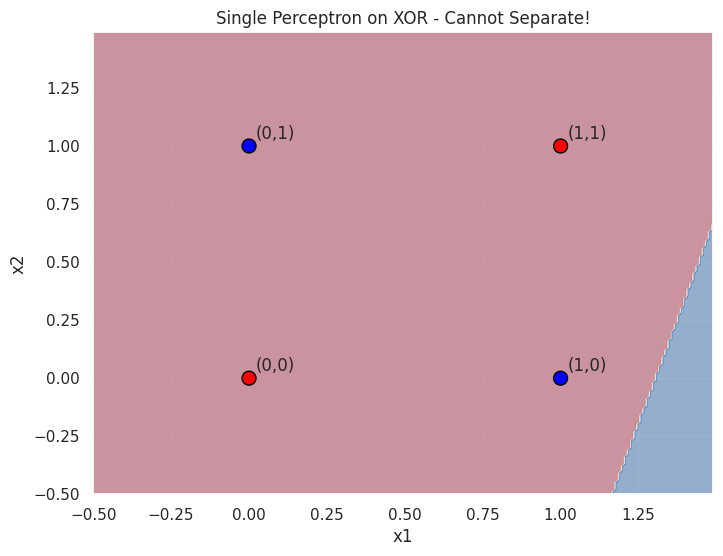

In [5]:
def plot_decision_boundary(X, y, weights, title):
    # Create a mesh
    h = 0.01
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Add bias term
    Z = g(np.c_[xx.ravel(), yy.ravel(), -np.ones(xx.ravel().shape[0])], weights)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

    # Plot points
    colors = ['red' if label == 0 else 'blue' for label in y]
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors, s=100, edgecolors='black')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.grid(True, alpha=0.3)

    # Add labels to points
    for i, (x1, x2) in enumerate(X.values):
        plt.annotate(f'({int(x1)},{int(x2)})', (x1, x2), xytext=(5, 5),
                    textcoords='offset points')

    plt.show()

# Visualize XOR problem
plot_decision_boundary(inputs, target, w_xor,
                      'Single Perceptron on XOR - Cannot Separate!')

## The Solution: Multi-Layer Neural Network


In [ ]:
Now let's implement a 2-layer neural network that can solve XOR:

In [6]:
class TwoLayerNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights with Xavier initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        # Backward propagation
        m = X.shape[0]

        # Calculate gradients
        self.dz2 = output - y.reshape(-1, 1)
        self.dW2 = (1/m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1/m) * np.sum(self.dz2, axis=0, keepdims=True)

        da1 = np.dot(self.dz2, self.W2.T)
        self.dz1 = da1 * self.sigmoid_derivative(self.a1)
        self.dW1 = (1/m) * np.dot(X.T, self.dz1)
        self.db1 = (1/m) * np.sum(self.dz1, axis=0, keepdims=True)

    def update_parameters(self, learning_rate):
        # Update weights and biases
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2

    def train(self, X, y, epochs, learning_rate):
        losses = []

        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)

            # Calculate loss
            loss = np.mean((output - y.reshape(-1, 1))**2)
            losses.append(loss)

            # Backward propagation
            self.backward(X, y, output)

            # Update parameters
            self.update_parameters(learning_rate)

            if epoch % 1000 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')

        return losses

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

## Training the Multi-Layer Network on XOR

In [7]:
# Create and train the network
np.random.seed(42)
nn = TwoLayerNetwork(input_size=2, hidden_size=4, output_size=1)

# Prepare data
X_train = XOR[['x1', 'x2']].values
y_train = XOR['y'].values

# Train the network
losses = nn.train(X_train, y_train, epochs=10000, learning_rate=1.0)

# Make predictions
predictions = nn.predict(X_train)

print("\nFinal predictions:")
print(predictions.flatten())
print("\nTarget values:")
print(y_train)
print("\nAccuracy:", np.mean(predictions.flatten() == y_train))

Epoch 0, Loss: 0.2683
Epoch 1000, Loss: 0.0004
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 5000, Loss: 0.0000
Epoch 6000, Loss: 0.0000
Epoch 7000, Loss: 0.0000
Epoch 8000, Loss: 0.0000
Epoch 9000, Loss: 0.0000

Final predictions:
[0 1 1 0]

Target values:
[0 1 1 0]

Accuracy: 1.0


## Visualizing the Learning Process

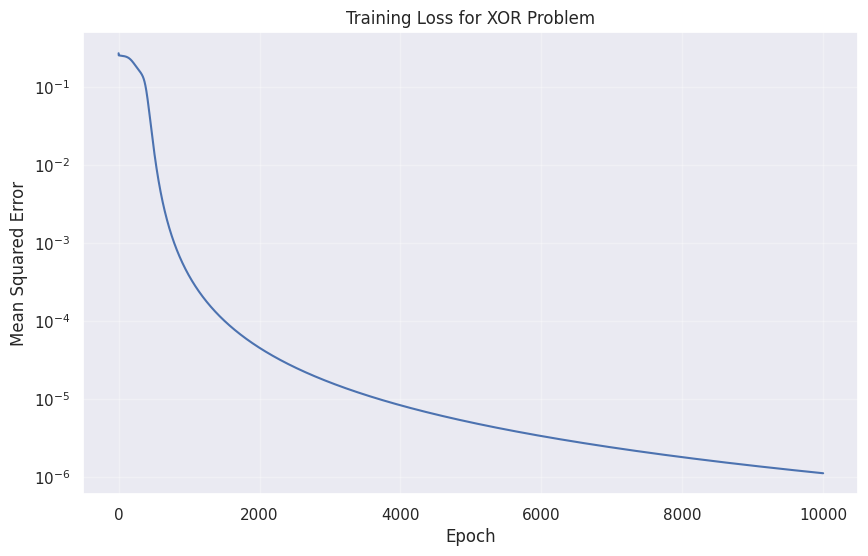

In [8]:
# Plot loss over time
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss for XOR Problem')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing the Decision Boundary

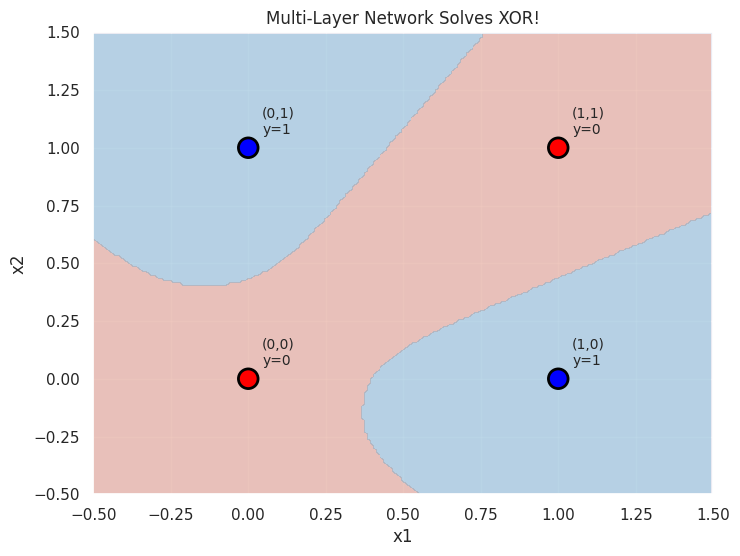

In [9]:
def plot_nn_decision_boundary(nn, X, y, title):
    # Create a mesh
    h = 0.01
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on mesh
    Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu', levels=[0, 0.5, 1])

    # Plot points
    colors = ['red' if label == 0 else 'blue' for label in y]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=200, edgecolors='black', linewidth=2)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.grid(True, alpha=0.3)

    # Add labels to points
    for i, (x1, x2) in enumerate(X):
        plt.annotate(f'({int(x1)},{int(x2)})\ny={y[i]}',
                    (x1, x2), xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=10)

    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.show()

# Visualize the solution
plot_nn_decision_boundary(nn, X_train, y_train,
                         'Multi-Layer Network Solves XOR!')

## Understanding Hidden Layer Representations

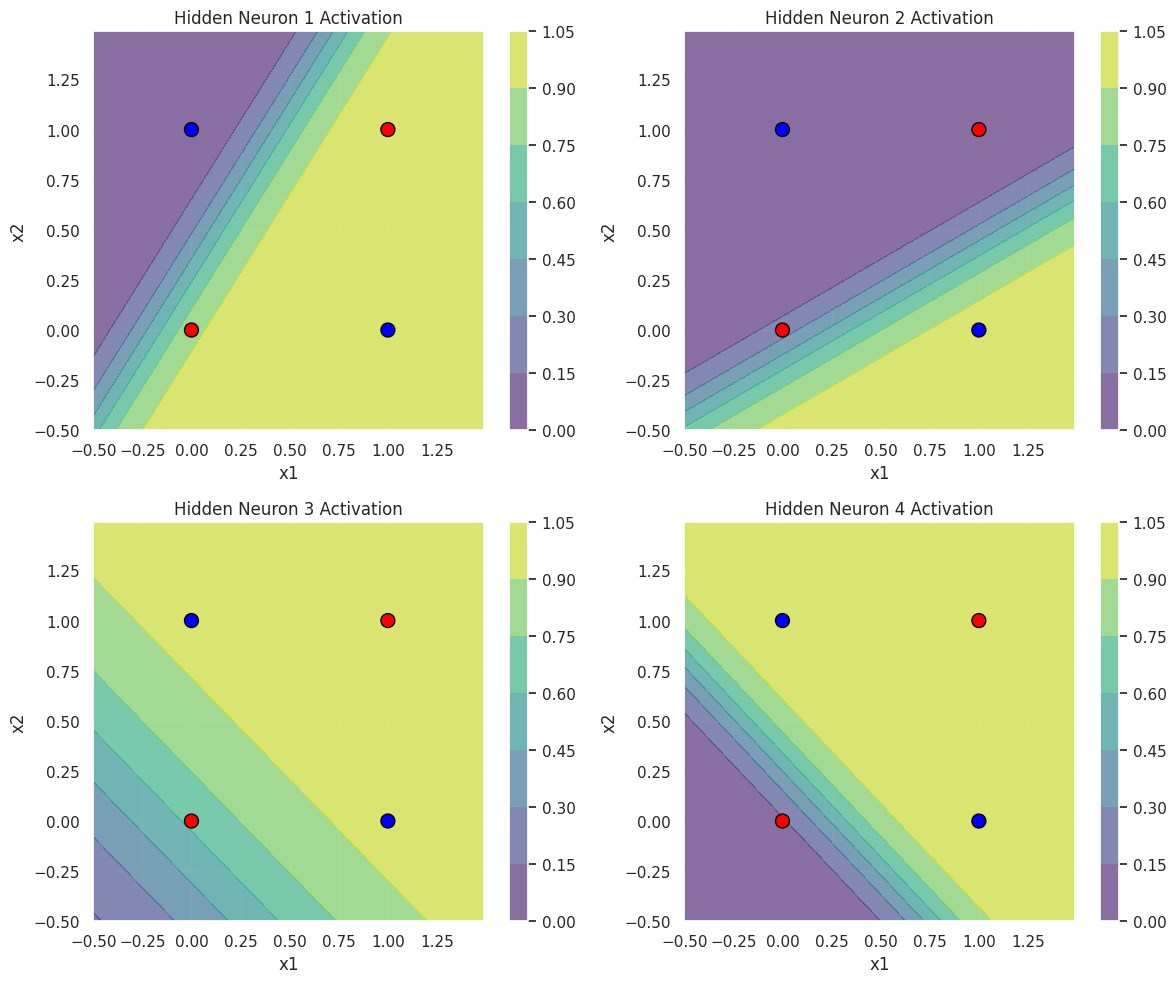

In [10]:
def visualize_hidden_layer(nn, X, y):
    # Get hidden layer activations
    _ = nn.forward(X)
    hidden_activations = nn.a1

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i in range(4):
        ax = axes[i]

        # Create a mesh
        h = 0.01
        x_min, x_max = -0.5, 1.5
        y_min, y_max = -0.5, 1.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Get activation for this hidden neuron
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        _ = nn.forward(grid_points)
        Z = nn.a1[:, i].reshape(xx.shape)

        # Plot
        contour = ax.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')

        # Plot data points
        colors = ['red' if label == 0 else 'blue' for label in y]
        ax.scatter(X[:, 0], X[:, 1], c=colors, s=100, edgecolors='black')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title(f'Hidden Neuron {i+1} Activation')
        ax.grid(True, alpha=0.3)

        # Add colorbar
        plt.colorbar(contour, ax=ax)

    plt.tight_layout()
    plt.show()

# Visualize what each hidden neuron learns
visualize_hidden_layer(nn, X_train, y_train)

## Comparing All Logical Functions

Epoch 0, Loss: 0.2231
Epoch 1000, Loss: 0.0000
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 0, Loss: 0.3441
Epoch 1000, Loss: 0.0000
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 0, Loss: 0.2683
Epoch 1000, Loss: 0.0004
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000


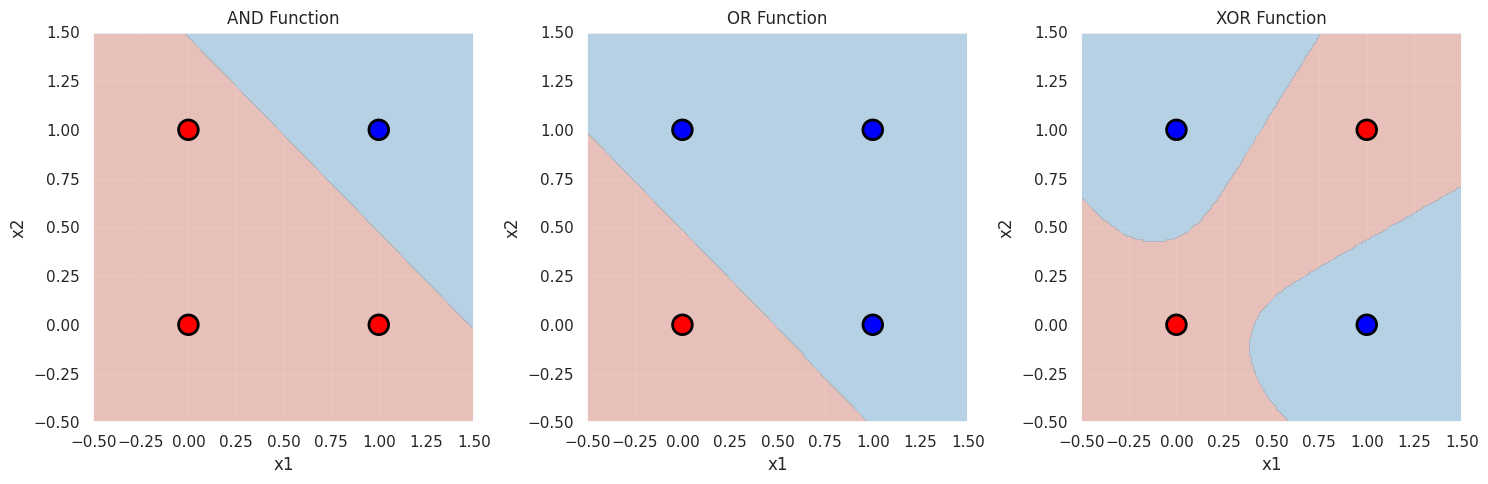

In [11]:
# Train networks for all logical functions
functions = {
    'AND': AND,
    'OR': OR,
    'XOR': XOR
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, df) in enumerate(functions.items()):
    X = df[['x1', 'x2']].values
    y = df['y'].values

    # Train network
    np.random.seed(42)
    network = TwoLayerNetwork(2, 4, 1)
    network.train(X, y, epochs=5000, learning_rate=1.0)

    # Plot decision boundary
    ax = axes[idx]
    h = 0.01
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = network.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu', levels=[0, 0.5, 1])

    colors = ['red' if label == 0 else 'blue' for label in y]
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=200, edgecolors='black', linewidth=2)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(f'{name} Function')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

## Key Insights
1. **Single Perceptron Limitation**: A single perceptron can only create linear decision boundaries. XOR requires a non-linear boundary, which is why it fails.

2. **Multi-Layer Solution**: By adding a hidden layer, the network can combine multiple linear boundaries to create non-linear decision regions.

3. **Hidden Layer Function**: Each hidden neuron learns to respond to different patterns in the input space. The output layer then combines these patterns to solve XOR.

4. **Universal Approximation**: With enough hidden neurons, a 2-layer network can approximate any continuous function, including XOR.

## Exercise: Experiment with the Network
Try modifying the following parameters and observe the effects:

1. **Hidden layer size**: Try 2, 3, 4, 8 hidden neurons
2. **Learning rate**: Try 0.1, 0.5, 1.0, 2.0
3. **Activation functions**: Implement ReLU or tanh instead of sigmoid
4. **Initialization**: Try different weight initialization strategies

# Your experimentation code here
# Example: Try with 2 hidden neurons
nn_small = TwoLayerNetwork(input_size=2, hidden_size=2, output_size=1)
losses_small = nn_small.train(X_train, y_train, epochs=10000, learning_rate=1.0)

print("Accuracy with 2 hidden neurons:",
      np.mean(nn_small.predict(X_train).flatten() == y_train))

## Conclusion

The XOR problem perfectly illustrates why deep learning exists. Simple linear models fail on non-linearly separable data, but adding even one hidden layer with non-linear activation functions enables the network to learn complex patterns. This principle scales up to deep networks with many layers, enabling them to learn incredibly complex functions for tasks like image recognition and natural language processing.

## Why can't a single perceptron solve XOR?
Answer:
 A single-layer perceptron is a linear classifier.It can only learn and classify patterns that are "linearly separable" problem.
 The XOR problem requires a non-linear decision boundary. A multi-layer neural network with one or more hidden layers can solve the XOR problem.
 That's why single perceptron cannot solve XOR.


## What is the minimum number of hidden neurons needed?
Answer: The minimum is 2 hidden neurons in a single hidden layer.

## How do hidden layers enable non-linear decision boundaries?
Answer: Hidden layers enable non-linear decision boundaries by combining multiple linear transformations with non-linear activation functions, which      allows the neural network to learn complex, curved decision surfaces.